In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [2]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [3]:
class Config:
    # base path to YOLO directory
    MODEL_PATH = "pretrained_models"   # This folder contains the COCO names(AKA labels) & configuration & weights

    # initialize minimum probability to filter weak detections along with
    # the threshold when applying non-maxima suppression
    MIN_CONF = 0.3
    NMS_THRESH = 0.3

    # boolean indicating if NVIDIA CUDA GPU should be used
    USE_GPU = False

    # define the minimum safe distance (in pixels) that two people can be
    # from each other
    MIN_DISTANCE = 50

# instantiate our Config object
config = Config()

In [4]:
args = {
    "input": "singapore_mall.mp4",
    "output": "output_singapore_mall.mp4",
    "display": 0
}

In [5]:
def detect_people(frame, net, ln, personIdx=0):
	# 	frame: The frame from your video file or directly from your webcam
	# net: The pre-initialized and pre-trained YOLO object detection model
	# ln: The YOLO CNN output layer names
	# personIdx: The YOLO model can detect many types of objects; this index is specifically for the person class, as we won’t be considering other objects


	# grab the dimensions of the frame and  initialize the list of results ==> for scaling purposes.
	(H, W) = frame.shape[:2]
	results = []

    # construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)


	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
	boxes = []
	centroids = []
	confidences = []

    # loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter detections by (1) ensuring that the object
			# detected was a person and (2) that the minimum
			# confidence is met
			if classID == personIdx and confidence > config.MIN_CONF:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# centroids, and confidences
				boxes.append([x, y, int(width), int(height)])
				centroids.append((centerX, centerY))
				confidences.append(float(confidence))

    # apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, config.MIN_CONF, config.NMS_THRESH)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# update our results list to consist of the person
			# prediction probability, bounding box coordinates,
			# and the centroid
			r = (confidences[i], (x, y, x + w, y + h), centroids[i])
			results.append(r)

	# return the list of results
	return results

In [6]:
def compute_point_perspective_transformation(matrix,list_downoids):
  """ Apply the perspective transformation to every ground point which have been detected on the main frame.
  @ matrix : the 3x3 matrix
  @ list_downoids : list that contains the points to transform
  return : list containing all the new points
  """
  # Compute the new coordinates of our points
  list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
  transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
  # Loop over the points and add them to the list that will be returned
  transformed_points_list = list()
  for i in range(0,transformed_points.shape[0]):
    transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
  return transformed_points_list

In [7]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([config.MODEL_PATH, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([config.MODEL_PATH, "yolov3.weights"])
configPath = os.path.sep.join([config.MODEL_PATH, "yolov3.cfg"])

In [8]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


# Obtaining perspectiveTransformation matrix

In [9]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream and pointer to output video file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

[INFO] accessing video stream...


In [10]:
(grabbed, frame) = vs.read()

In [11]:
# resize the frame and then detect people (and only people) in it
print(frame.shape)
print("="*50)
frame = imutils.resize(frame, width=700)
print(frame.shape)

(720, 1280, 3)
(393, 700, 3)


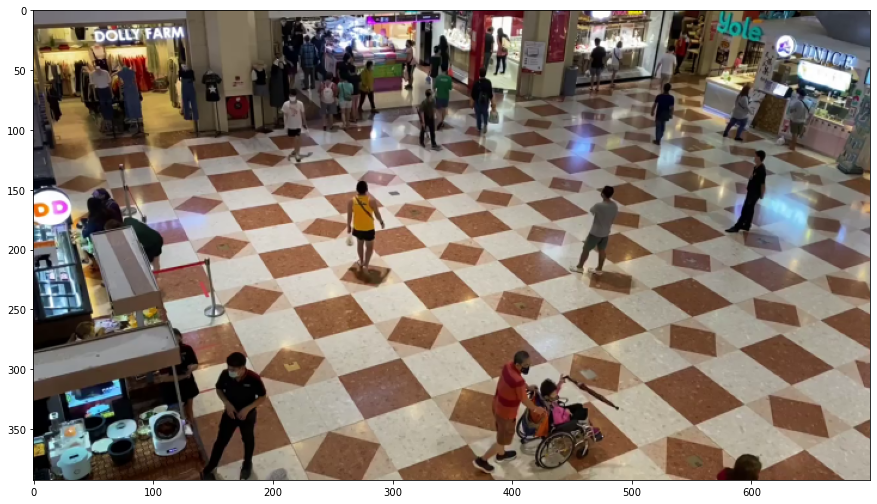

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [45]:
cv2.imwrite("singapore_mall_frame.jpg",frame)

True

In [13]:
results = detect_people(frame, net, ln, personIdx=LABELS.index("person"))
# (startX, startY, endX, endY) = bbox
# X is the width, Y is the height of the rectangles
# (cX, cY) = centroid
results

[(0.9950204491615295, (452, 146, 488, 223), (470, 185)),
 (0.990945041179657, (584, 117, 611, 188), (598, 153)),
 (0.9856839776039124, (258, 141, 291, 217), (275, 179)),
 (0.971580982208252, (516, 61, 538, 112), (527, 87)),
 (0.9504099488258362, (363, 53, 384, 103), (374, 78)),
 (0.9185482859611511, (324, 42, 346, 116), (335, 79)),
 (0.8633819818496704, (239, 54, 256, 99), (248, 77)),
 (0.8599435687065125, (626, 67, 650, 116), (638, 92)),
 (0.8405717611312866, (579, 63, 606, 108), (593, 86)),
 (0.7571069598197937, (467, 24, 482, 59), (475, 42)),
 (0.7283029556274414, (379, 282, 415, 386), (397, 334)),
 (0.7100637555122375, (272, 40, 286, 90), (279, 65)),
 (0.6872719526290894, (223, 20, 242, 63), (233, 42)),
 (0.5050179958343506, (52, 39, 82, 104), (67, 72)),
 (0.5030618906021118, (206, 69, 228, 105), (217, 87)),
 (0.4637168347835541, (335, 20, 347, 57), (341, 39)),
 (0.4620269238948822, (254, 49, 269, 97), (262, 73)),
 (0.3686857223510742, (520, 30, 539, 68), (530, 49)),
 (0.3528143763

In [14]:
centroids = np.array([r[2] for r in results])

In [15]:
downroid_X = [r[2][0] for r in results]
downroid_Y = [r[1][3] for r in results]
downroid = list(zip(downroid_X,downroid_Y))

In [16]:
pt1 = [48,107]
pt2 = [411,67]
pt3 = [700,208]
pt4 = [148,383]

width = int(round(max(   np.sqrt((pt1[0]**2 + pt2[0]**2))    ,   np.sqrt((pt3[0]**2 + pt4[0]**2))  ),0))
height = int(round(max(   np.sqrt((pt1[1]**2 + pt2[1]**2))    ,   np.sqrt((pt3[1]**2 + pt4[1]**2))  ),0))

# width , height = 700,700
print(width,height)

original_points = np.float32([pt1,pt2,pt4,pt3])
transformed_points = np.float32([[0,0],[width,0],[0,height],[width,height]])

matrix = cv2.getPerspectiveTransform(original_points,transformed_points)

715 436


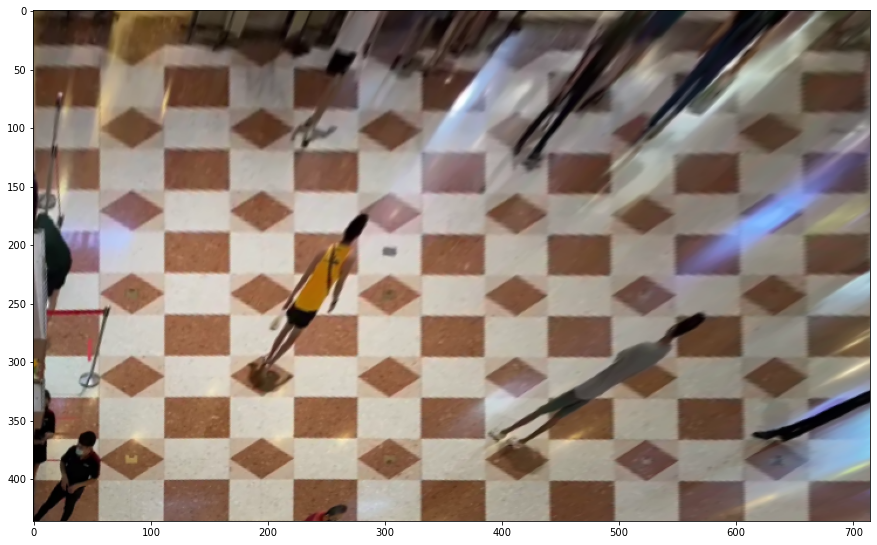

In [17]:
result = cv2.warpPerspective(frame,matrix,(width , height))
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [51]:
cv2.imwrite("singapore_mall_frame_transfomed.jpg",result)

True

In [17]:
transformed_downoids = compute_point_perspective_transformation(matrix,downroid)
transformed_downoids

[[403.94724, 375.07196],
 [631.9128, 373.14246],
 [195.412, 306.07977],
 [757.3245, 199.09981],
 [518.2452, 109.69238],
 [421.14395, 130.91571],
 [315.78305, 47.436874],
 [943.34515, 258.35776],
 [895.8095, 218.0285],
 [897.1266, -4.1535873],
 [177.73505, 494.13132],
 [386.98438, 29.95206],
 [366.99927, -93.63826],
 [29.238962, -2.864313],
 [255.57841, 54.34522],
 [606.678, -74.993515],
 [342.8683, 46.456425],
 [972.14746, 60.039543],
 [23.718634, -64.574234],
 [744.1632, -75.191956],
 [-39.711586, -49.869965]]

In [18]:
D = dist.cdist(transformed_downoids, transformed_downoids, metric="euclidean")
D.shape

(21, 21)

In [19]:
breached_D = D  < config.MIN_DISTANCE

In [20]:
(breached_D.sum(axis=1) -1)>=2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False])

In [21]:
violate = np.where((breached_D.sum(axis=1) -1)>=2)[0]

# If we want to flag the whole group as red:
violate = set(np.where(breached_D[violate])[1])

violate

{6, 11, 16}

In [22]:
# loop over the results
for (i, (prob, bbox, centroid)) in enumerate(results):
	# extract the bounding box and centroid coordinates, then
	# initialize the color of the annotation
	(startX, startY, endX, endY) = bbox
	# (cX, cY) = centroid
	(cX, cY) = downroid[i]
	color = (0, 255, 0)

	# if the index pair exists within the violation set, then
	# update the color
	if i in violate:
		color = (0, 0, 255)

	# draw (1) a bounding box around the person and (2) the
	# centroid coordinates of the person,
	cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	cv2.circle(frame, (cX, cY), 5, color, 1)

	cv2.putText(frame, str(i), (cX, cY+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
	# cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)


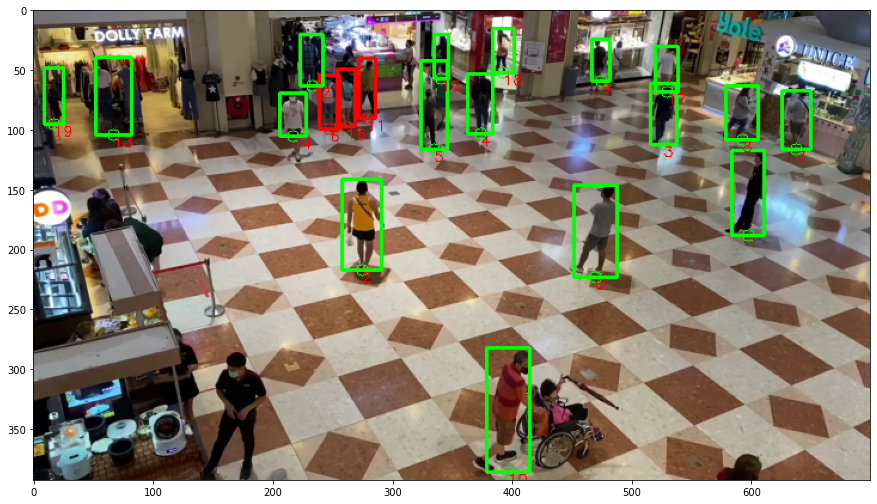

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
D[16]

array([334.24363619, 436.20004923, 298.57601798, 441.67179605,
       186.42918408, 115.15403042,  27.10297528, 636.76890901,
       578.94816214, 556.56413584, 477.16013683,  47.10226458,
       142.1577466 , 317.48368148,  87.6456199 , 290.42321129,
         0.        , 629.42575491, 419.32796562, 394.52012856])

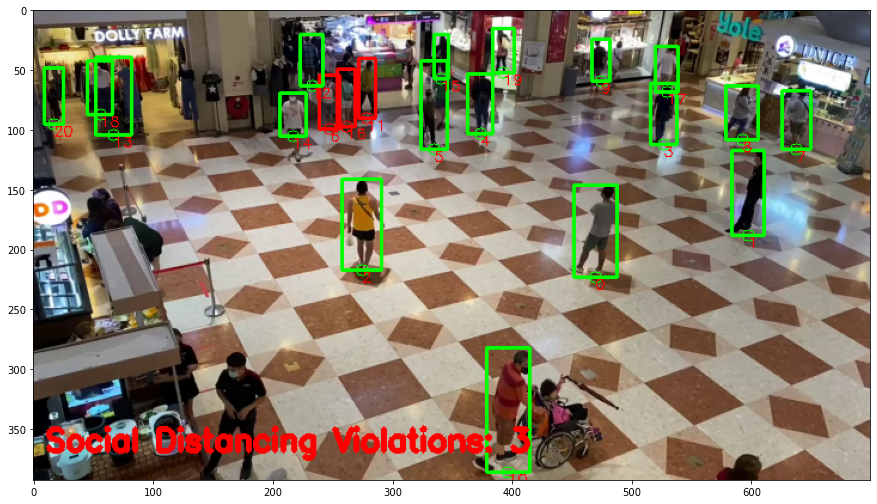

In [23]:
# draw the total number of social distancing violations on the
# output frame
text = "Social Distancing Violations: {}".format(len(violate))
cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
cv2.imwrite("output_singapore_mall_frame.jpg",frame)

True

# Safe Distancing Detector

In [9]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream and pointer to output video file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

[INFO] accessing video stream...


In [10]:
pt1 = [48,107]
pt2 = [411,67]
pt3 = [700,208]
pt4 = [148,383]

width = int(round(max(   np.sqrt((pt1[0]**2 + pt2[0]**2))    ,   np.sqrt((pt3[0]**2 + pt4[0]**2))  ),0))
height = int(round(max(   np.sqrt((pt1[1]**2 + pt2[1]**2))    ,   np.sqrt((pt3[1]**2 + pt4[1]**2))  ),0))

# width , height = 700,700
print(width,height)

original_points = np.float32([pt1,pt2,pt4,pt3])
transformed_points = np.float32([[0,0],[width,0],[0,height],[width,height]])

matrix = cv2.getPerspectiveTransform(original_points,transformed_points)

715 436


In [156]:
# counter = 0

In [11]:
# loop over the frames from the video stream
while True:
    # Reducing the frames per second to cut processing time
    # counter += 1
    # if counter%3==0:
    #     vs.read()
    #     continue

    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # resize the frame and then detect people (and only people) in it
    frame = imutils.resize(frame, width=700)
    results = detect_people(frame, net, ln,
        personIdx=LABELS.index("person"))

    # initialize the set of indexes that violate the minimum social
    # distance
    violate = set()

    # ensure there are *at least* two people detections (required in
    # order to compute our pairwise distance maps)
    if len(results) >= 2:
        # extract all centroids from the results and compute the
        # Euclidean distances between all pairs of the centroids
        downroid_X = [r[2][0] for r in results]
        downroid_Y = [r[1][3] for r in results]
        downroid = list(zip(downroid_X,downroid_Y))
        transformed_downoids = compute_point_perspective_transformation(matrix,downroid)

        D = dist.cdist(transformed_downoids, transformed_downoids, metric="euclidean")

        breached_D = D  < config.MIN_DISTANCE
        violate = np.where((breached_D.sum(axis=1) -1)>=2)[0]

        # If we want to flag the whole group as red:
        violate = set(np.where(breached_D[violate])[1])
        
    # loop over the results
    for (i, (prob, bbox, centroid)) in enumerate(results):
        # extract the bounding box and centroid coordinates, then
        # initialize the color of the annotation
        (startX, startY, endX, endY) = bbox
        # (cX, cY) = centroid
        (cX, cY) = downroid[i]
        color = (0, 255, 0)

        # if the index pair exists within the violation set, then
        # update the color
        if i in violate:
            color = (0, 0, 255)

        # draw (1) a bounding box around the person and (2) the
        # centroid coordinates of the person,
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        cv2.circle(frame, (cX, cY), 5, color, 1)

    # draw the total number of social distancing violations on the
    # output frame
    text = "Social Distancing Violations: {}".format(len(violate))
    cv2.putText(frame, text, (10, frame.shape[0] - 25),
        cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

    # check to see if the output frame should be displayed to our
    # screen
    if args["display"] > 0:
        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # if an output video file path has been supplied and the video
    # writer has not been initialized, do so now
    if args["output"] != "" and writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MP4V")
        writer = cv2.VideoWriter(args["output"], fourcc, 25,
            (frame.shape[1], frame.shape[0]), True)

    # if the video writer is not None, write the frame to the output
    # video file
    if writer is not None:
        writer.write(frame)

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
    writer.release()
